In [3]:
import matplotlib.pyplot as plt
import numpy as np
from snaptools import snapio
from snaptools import plot_tools
from snaptools import utils
from functools import partial
from snaptools import manipulate as man
import conversions as co
import matplotlib.patheffects as PathEffects
import h5py
from mpl_toolkits.axes_grid1 import Grid

colors = ['#332288', '#CC6677', '#6699CC', '#117733']

%matplotlib inline

/usr/users/spardy/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
co.UnitTime_in_Gyr

0.9784620750887875

In [5]:
IC_stem = '/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/stars2gas/output_stars2gas/'
stem = '/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/collisions_best/output_Dehnen_smc_45deg/'

In [6]:
times = np.empty((82, 2))
starformation = np.empty((82, 2))
for i, folder in enumerate((IC_stem, stem)):
    for si in xrange(82):
        with h5py.File(folder + 'snap_'+ str(si).zfill(3) +'.hdf5') as f:
            time = f['/Header'].attrs['Time']
            if i == 0:
                times[si, i] = time - 4
                dt = 0.05
            else:
                times[si, i] = time
                dt = 0.025
            try:
                starformation[si, i] = np.sum(f['PartType4/StellarFormationTime/'][()] >= time-dt)
            except:
                starformation[si, i] = 0





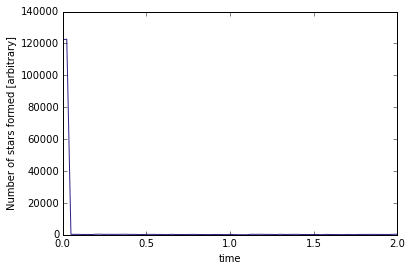

In [8]:
snap = snapio.load_snap(folder + 'snap_000.hdf5')
MASS = snap.masses['sfr'].mean()
#plt.plot(times[:, 0], starformation[:, 0])
plt.plot(times[:, 1], starformation[:, 1])
plt.xlabel('time')
plt.ylabel('Number of stars formed [arbitrary]')
#plt.ylim([0])
plt.savefig('/usr/users/spardy/starformation.png')


0.0461834497401


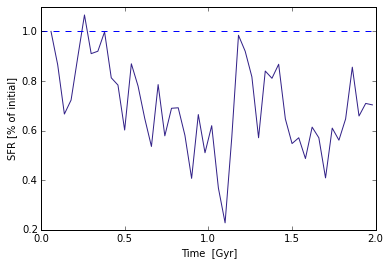

In [9]:
snap = snapio.load_snap(stem + 'snap_'+ str(81).zfill(3) +'.hdf5')
masses = snap.masses['sfr']
formation_time = snap.misc['sfr']['AGE '][snap.misc['sfr']['AGE '] > 0]
time_range = [0, 2.0]
n_bins = 50
hist, bins = np.histogram(formation_time, bins=n_bins, range=time_range,)
inds = np.digitize(formation_time, bins=bins)
time = (bins[:-1] + bins[1:])/2

sfr = np.array([masses[inds == j].sum()*10/(bins[j+1]-bins[j])
                for j in range(len(time))])
sfr[sfr == 0] = np.nan

plt.plot(time, sfr/sfr[1])
print(sfr[1])

plt.xlabel('Time  [Gyr]')
#plt.ylabel('SFR  [M$_\odot$ yr$^{-1}$]')
plt.ylabel('SFR [% of initial]')
plt.axhline(y=1, linestyle='--')
#plt.savefig("/d/www/spardy/images/HST_Magellanics/SFR_time.pdf", dpi=400)

In [10]:
HSML = np.empty((82, 2))
SFR = np.empty((82, 2))
NH = np.empty((82, 2))
NE = np.empty((82, 2))
RHO = np.empty((82, 2))
U = np.empty((82, 2))
times = np.empty((82, 2))
for i, folder in enumerate((IC_stem, stem)):
    for si in xrange(82):
        with h5py.File(folder + 'snap_'+ str(si).zfill(3) +'.hdf5') as f:
            times[si, i] = f['/Header'].attrs['Time']
            if i == 0:
                times[si, i] -= 4
            HSML[si, i] = np.mean(f['/PartType0/SmoothingLength/'][()])
            SFR[si, i] = np.mean(f['/PartType0/StarFormationRate/'][()])
            NH[si, i] = np.mean(f['/PartType0/NeutralHydrogenAbundance/'][()])
            NE[si, i] = np.mean(f['/PartType0/ElectronAbundance/'][()])
            RHO[si, i] = np.mean(f['/PartType0/Density/'][()])
            U[si, i] = np.mean(f['/PartType0/InternalEnergy/'][()])


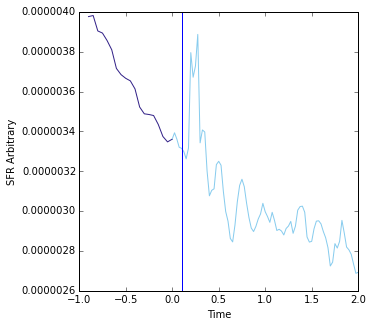

In [11]:
fig, axis = plt.subplots(1, figsize=(5, 5))
axis.plot(times[-20:, 0], SFR[-20:, 0]*10)
axis.plot(times[:, 1], SFR[:, 1]*10)
#axis.plot(time[:, 1], RHO[:, 1])
#axis.plot(time[:, 1], HSML[:, 1])
#plt.ylim([0.0005, 0.0015])
axis.axvline(x=0.1)
axis.set_ylabel('SFR Arbitrary')
axis.set_xlabel('Time')
#plt.savefig('/usr/users/spardy/starformation_gas.png')

## Star Formation Centers - Using all ParType4

In [12]:
def sfr_center(snap, ids, settings):
    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    new_stars = np.setdiff1d(snap.ids['sfr'], ids)
    new_stars_ids = np.empty(len(new_stars))
    for i, n in enumerate(new_stars):
        new_stars_ids[i] = np.where(snap.ids['sfr'] == n)[0] 
    
    px = snap.pos['sfr'][new_stars_ids.astype(int), 0] - com1[0]
    py = snap.pos['sfr'][new_stars_ids.astype(int), 1] - com1[1]
    masses = snap.masses['sfr'][new_stars_ids.astype(int)]
    Z2, ind1, ind2 = man.bin_particles(px, py, 15, 15, masses, 512, True)
    measurements = man.fit_contours(Z2 > 0, settings(in_max=1), numcontours=1)
    time = snap.header['time'] * co.UnitTime_in_Gyr * 1000.0
    return time, measurements['xCenters'][0], measurements['yCenters'][0]


In [13]:
snaps = xrange(0, 81)
settings = partial(utils.make_settings, xlen=15, ylen=15, first_only=True, com=True, in_min=0)
times = np.empty(81)
xs = np.empty(81)
ys = np.empty(81)
for i in snaps:
    snap2 = snapio.load_snap(stem + 'snap_'+ str(i+1).zfill(3) +'.hdf5')
    snap = snapio.load_snap(stem + 'snap_'+ str(i).zfill(3) +'.hdf5')
    t, x, y = sfr_center(snap2, snap.ids['sfr'], settings)
    times[i] = t
    xs[i] = x
    ys[i] = y

/usr/users/spardy/python/Gadget/snaptools/manipulate.py:67: RuntimeWarning: invalid value encountered in greater
  Z2[Z2 > 0] = np.log10(Z2[Z2 > 0])
/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


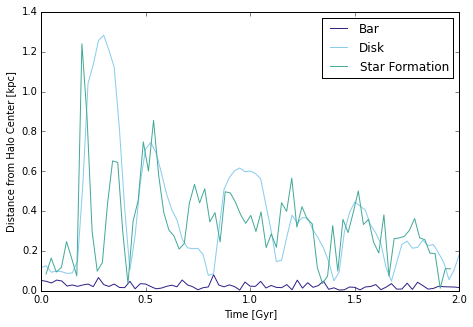

In [15]:
fig, axis = plt.subplots(1, figsize=(7.5,5))

with h5py.File('../Data/offSetsDehnen_best.hdf5', 'r') as DehnenOffSets:
    axis.plot(DehnenOffSets['/stars/45deg/time'][:],
              DehnenOffSets['/stars/45deg/bar_dist'][:], label='Bar')
    axis.plot(DehnenOffSets['/stars/45deg/time'][:],
              DehnenOffSets['/stars/45deg/disk_dist'][:], label='Disk')
axis.plot(times/1000., np.sqrt(xs**2 + ys**2), label='Star Formation')
axis.set_ylabel('Distance from Halo Center [kpc]')
axis.set_xlabel('Time [Gyr]')
axis.legend()
#plt.savefig('/usr/users/spardy/starformation_centers.png')

## Tracking Stars Formed at Particular Time

In [16]:
def track_sfr(snap, stars, settings):
    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    stars_ids = np.empty(len(stars))
    for i, n in enumerate(stars):
        stars_ids[i] = np.where(snap.ids['sfr'] == n)[0] 
    
    com1h, com2h, idgal1h, idgal2h = snap.center_of_mass('halo')
    pot_cent = snap.potential_center(com1h, idgal1h, offset=com1)
    px = snap.pos['sfr'][stars_ids.astype(int), 0] - com1[0]
    py = snap.pos['sfr'][stars_ids.astype(int), 1] - com1[1]
    time = snap.header['time'] * co.UnitTime_in_Gyr*1000.0
    return time, px.mean(), py.mean()



/usr/users/spardy/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/users/spardy/.local/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


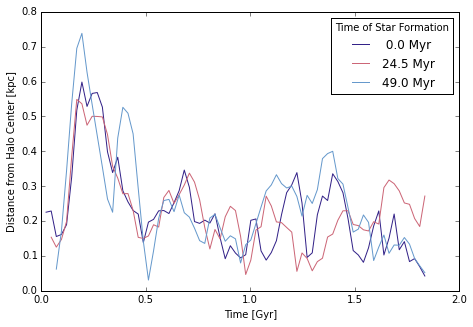

In [18]:
panels = [4, 5, 6]
settings = partial(utils.make_settings, xlen=15, ylen=15, first_only=True, com=True, in_min=0)

fig, axis = plt.subplots(1, figsize=(7.5, 5))


#    snap2 = io.load_snap(stem + 'snap_'+ str(panel).zfill(3) +'.hdf5')
#    snap = io.load_snap(stem + 'snap_'+ str(panel-1).zfill(3) +'.hdf5')
#    new_stars = np.setdiff1d(snap2.ids['sfr'], snap.ids['sfr'])
times = np.zeros((80, len(panels)))
xs = np.zeros((80, len(panels)))
ys = np.zeros((80, len(panels)))
for i in xrange(80):
    snap = snapio.load_snap(stem + 'snap_'+ str(i).zfill(3) +'.hdf5')
    com1, com2, idgal1, idgal2 = snap.center_of_mass('halo')
    for j, panel in enumerate(panels):
        new_stars = snap.ids['sfr'][np.where((snap.misc['sfr']['AGE '] >= 0.025*panel)*
                                             (snap.misc['sfr']['AGE '] <= 0.025*(panel+1)))[0]]
        t, x, y = track_sfr(snap, new_stars, settings)
        times[i, j] = t
        xs[i, j] = x
        ys[i, j] = y      
    
for j, panel in enumerate(panels):
    axis.plot((times[:, j]-97.8)/1000., np.sqrt(xs[:, j]**2 + ys[:, j]**2),
              label='%4.1f Myr' % (times[panel, 0]-97.8), color=colors[j])
axis.legend(title='Time of Star Formation')
axis.set_xlabel('Time [Gyr]')
axis.set_ylabel('Distance from Halo Center [kpc]')
#plt.savefig('/d/www/spardy/images/HST_Magellanics/SFR_centers.pdf', dpi=400)

## Plot Panels of Star Formation

In [35]:
def do_plot(snap, ids, axis, settings):
    settings = settings()
    bin_dict = snap.bin_snap(settings)
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery)
    axis.pcolormesh(centerX, centerY, bin_dict['Z2'], cmap=settings['colormap'],
                    vmin=settings['in_min'], vmax=settings['in_max'])
    axis.set_xlim(-settings['xlen'], settings['xlen'])
    axis.set_ylim(-settings['ylen'], settings['ylen'])

    #plot_tools.plot_panel(axis, 'Z2', bin_dict, settings())
    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    new_stars = np.setdiff1d(snap.ids['sfr'], ids)
    new_stars_ids = np.empty(len(new_stars))
    for i, n in enumerate(new_stars):
        new_stars_ids[i] = np.where(snap.ids['sfr'] == n)[0] 
    
    px = snap.pos['sfr'][new_stars_ids.astype(int), 0] - com1[0]
    py = snap.pos['sfr'][new_stars_ids.astype(int), 1] - com1[1]
    masses = snap.masses['sfr'][new_stars_ids.astype(int)]
    Z2, ind1, ind2 = man.bin_particles(px, py, 15, 15, masses, 512, True)
    axis.contour(Z2 > 0, extent=[-15, 15, -15, 15], levels=[0.5])
    #measurements = man.fit_contours(Z2 > 0, settings(in_max=1), numcontours=1)
    
    #axis.plot(measurements['xCenters'][0], measurements['yCenters'][0], 'b+')
    time = snap.header['time'] * co.UnitTime_in_Gyr * 1000.0
    txt = axis.annotate("%4.1f Myr" % (time-97.8),
                        fontsize=10,
                        xy=(.2, .8), xycoords='axes fraction',
                        textcoords='axes fraction',
                        xytext=(.2, .8), color='black')

    txt.set_path_effects([PathEffects.withStroke(linewidth=3,
                                                 foreground="w")])

## Star Formation within last 25 Myr (1 snapshot)

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


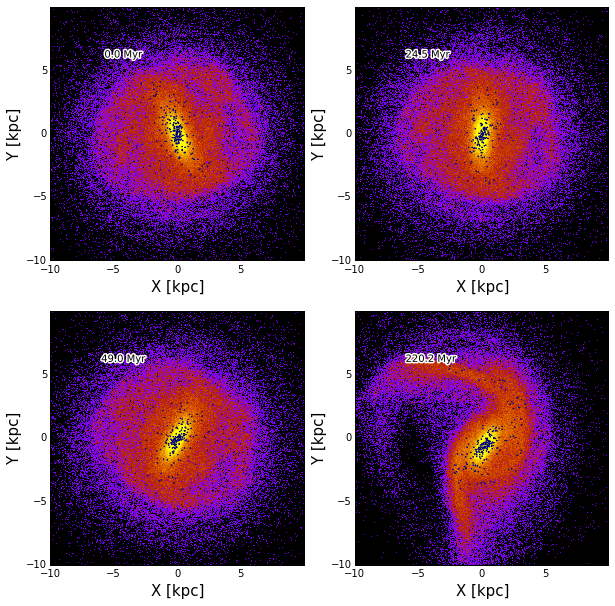

In [36]:
panels = [3, 4, 5, 12]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
#fig = plt.figure(figsize=(10, 10))
#grid = Grid(fig, 111,
#            nrows_ncols=(2, 2),
#            axes_pad=0.0,
#            label_mode="L",
#            share_all=True
#            )
axes = axes.flatten()
settings = partial(utils.make_settings, xlen=10, ylen=10, first_only=True, com=True, in_min=0)
for i, (axis, panel) in enumerate(zip(axes, panels)):
    snap2 = snapio.load_snap(stem + 'snap_'+ str(panel+1).zfill(3) +'.hdf5')
    snap = snapio.load_snap(stem + 'snap_'+ str(panel).zfill(3) +'.hdf5')
    do_plot(snap2, snap.ids['sfr'], axis, settings)
    axis.set_xlabel('X [kpc]', fontsize=15)
    axis.set_ylabel('Y [kpc]', fontsize=15)
    if i >= 0:
        xticks = axis.xaxis.get_major_ticks()
        yticks = axis.yaxis.get_major_ticks()
        yticks[-1].label1.set_visible(False)
        xticks[-1].label1.set_visible(False)

#plt.savefig('/d/www/spardy/images/HST_Magellanics/SFR_location.pdf', dpi=400)

## Star Formation within last 50 Myr (2 snapshots)

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


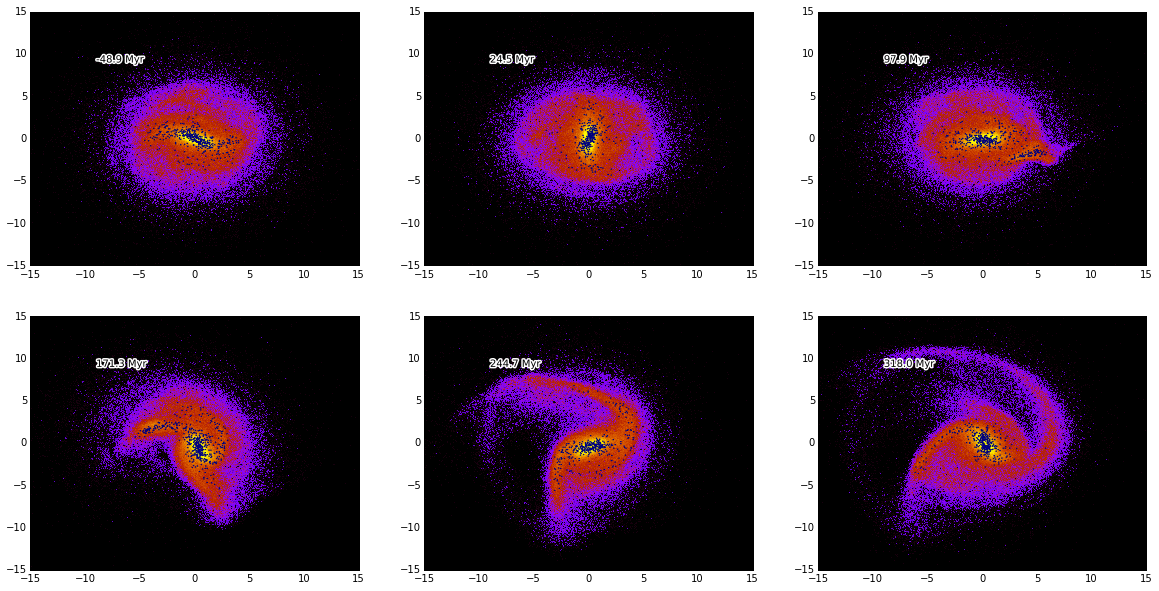

In [37]:
panels = [0, 3, 6, 9, 12, 15]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
settings = partial(utils.make_settings, xlen=15, ylen=15, first_only=True, com=True, in_min=0)
for axis, panel in zip(axes, panels):
    snap2 = snapio.load_snap(stem + 'snap_'+ str(panel+2).zfill(3) +'.hdf5')
    snap = snapio.load_snap(stem + 'snap_'+ str(panel).zfill(3) +'.hdf5')
    do_plot(snap2, snap.ids['sfr'], axis, settings)


## Star Formation Since Simulation Start

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


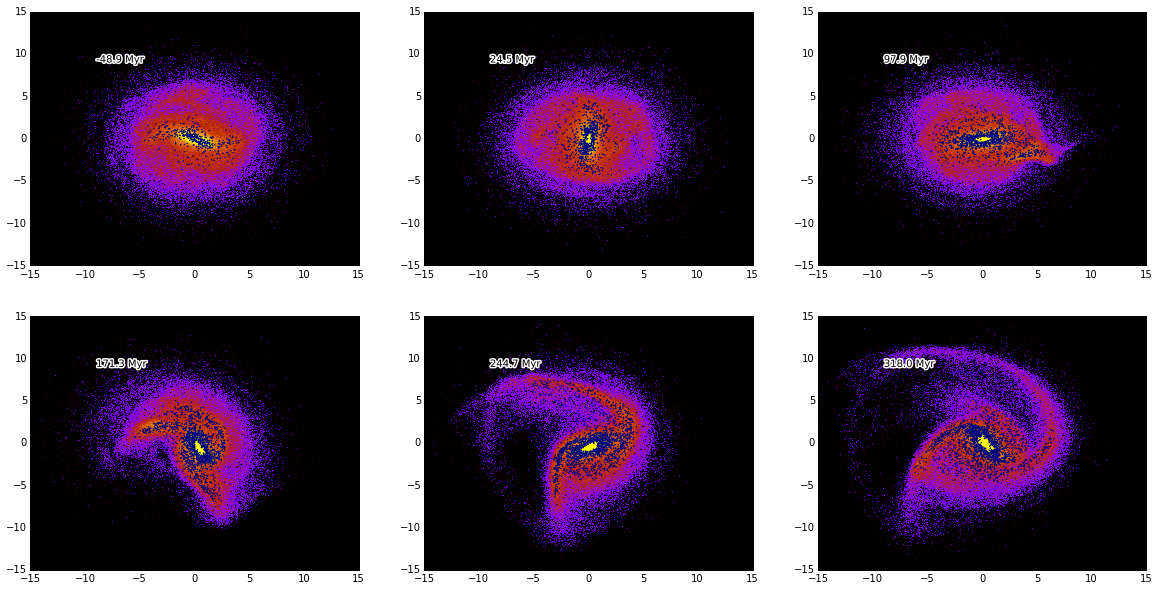

In [38]:
panels = [0, 3, 6, 9, 12, 15]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
settings = partial(utils.make_settings, xlen=15, ylen=15, first_only=True, com=True, in_min=0)
snap = snapio.load_snap(stem + 'snap_000.hdf5')
for axis, panel in zip(axes, panels):
    snap2 = snapio.load_snap(stem + 'snap_'+ str(panel+2).zfill(3) +'.hdf5')
    do_plot(snap2, snap.ids['sfr'], axis, settings)

In [126]:
snap2 = io.load_snap(stem + 'snap_'+ str(2).zfill(3) +'.hdf5')
snap = io.load_snap(stem + 'snap_'+ str(1).zfill(3) +'.hdf5')

new_stars = np.setdiff1d(snap2.ids['sfr'], snap.ids['sfr'])
new_stars_ids = np.empty(len(new_stars))
for i, n in enumerate(new_stars):
    new_stars_ids[i] = np.where(snap2.ids['sfr'] == n)[0] 

remove_gas = np.setdiff1d(snap.ids['gas'], snap2.ids['gas'])
    
print len(snap.ids['gas']) - len(snap2.ids['gas'])
print len(snap.ids['sfr']) - len(snap2.ids['sfr'])



310
-310
